In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Setup the notebook.

In [3]:
import h5py
import math
import random
testNames=["bimolecular_partitioned_time_limit"]
test_names_bash_list=" ".join(testNames)

In [4]:
%%bash
rm -rf tmp && mkdir tmp

In [5]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [6]:
def buildLattice(filename):
    fp = h5py.File(filename, "a")
    sites=fp["/Model/Diffusion/LatticeSites"]
    sites[:,:,0:3] = 0
    sites[:,:,3] = 1
    sites[:,:,4:7] = 2
    initialCounts=fp["/Model/Reaction/InitialSpeciesCounts"]
    particles=fp["/Model/Diffusion/Lattice"]
    for i in range(len(initialCounts)):
        attempts = 0
        placed = 0
        while placed < initialCounts[i]:
            attempts += 1
            x = random.randint(0,particles.shape[0]-1)
            y = random.randint(0,particles.shape[1]-1)
            if i == 0:
                z = random.randint(0,2)
            elif i == 1:
                z = random.randint(4,6)
            elif i == 2:
                z = 3
            for p in range(particles.shape[3]):
                if particles[x,y,z,p] == 0xFF:
                    particles[x,y,z,p] = i
                    placed += 1
                    break
        print "Placed %d particles of type %d in %d attempts."%(placed,i,attempts)
    fp.close()

# Execute the simulations.

In [7]:
%%bash -s "$test_names_bash_list"
sbmlFilename="rdme_bimolecular.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}*
    lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=2 numberSpecies=3 numberSiteTypes=3 "latticeSize=[5,6,7]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,0)=[1e-10,1e-10,0;1e-10,1e-10,0;0,0,0;]" "DiffusionMatrix(:,:,1)=[0,0,0;0,1e-10,1e-10;0,1e-10,1e-10;]" "DiffusionMatrix(:,:,2)=[0,0,0;0,1e-10,0;0,0,0]" "ReactionLocationMatrix=[0,1,0;0,1,0]" > ${outputFilename}.setdm.log
    if [ ${testName} == "bimolecular_partitioned_time_limit" ]; then
        lm_setp ${outputFilename} maxTime=1e3 writeInterval=1e0 latticeWriteInterval=1e0 > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


In [8]:
# Construct the partitioned lattices.
for testName in testNames:
    buildLattice("tmp/%s.lm"%(testName))
print "Finished."

Placed 100 particles of type 0 in 100 attempts.
Placed 100 particles of type 1 in 100 attempts.
Placed 0 particles of type 2 in 0 attempts.
Finished.


In [9]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    lmes -sp -r 1-10 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


# Define some tests.

In [14]:
def test_bimolecular_time_limit_stats(testOutputFilename):
    
    # Calcualte some statistics about the species counts.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))

    # Plot the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,6)})
    ax=plt.subplot(2,3,1)
    plt.plot(times,mSim[:,0], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,3,2)
    plt.plot(times,mSim[:,1], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,3,3)
    plt.plot(times,mSim[:,2], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,3,4)
    plt.plot(times,vSim[:,0], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,3,5)
    plt.plot(times,vSim[:,1], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,3,6)
    plt.plot(times,vSim[:,2], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    fp.close()

    # Check the mean and variance.
    value = np.mean(mSim[len(mSim)//2:,0])
    if not isclose(value,64.0,1e-2): raise Exception("incorrect value for particle 0 mean",value)
    value = np.mean(mSim[len(mSim)//2:,1])
    if not isclose(value,64.0,1e-2): raise Exception("incorrect value for particle 1 mean",value)
    value = np.mean(mSim[len(mSim)//2:,2])
    if not isclose(value,36.0,1e-2): raise Exception("incorrect value for particle 2 mean",value)
    value = np.mean(vSim[len(mSim)//2:,0])
    if not isclose(value,13.5,5e-2): raise Exception("incorrect value for particle 0 variance",value)
    value = np.mean(vSim[len(mSim)//2:,1])
    if not isclose(value,13.5,5e-2): raise Exception("incorrect value for particle 1 variance",value)        
    value = np.mean(vSim[len(mSim)//2:,2])
    if not isclose(value,13.5,5e-2): raise Exception("incorrect value for particle 2 variance",value)        

In [15]:
def test_bimolecular_time_limit_density(testOutputFilename):
    
    # Calculate some statistic about the spatial density.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    count = 0
    lc = np.zeros((5,6,7,3), dtype=double)
    for replicate in replicates:
        lattices=fp["/Simulations/%s/Lattice"%replicate].keys()
        for lattice in lattices:
            lfull = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,lattice)], dtype=np.uint8)
            lc[:,:,:,0] += np.sum(lfull==0,3)
            lc[:,:,:,1] += np.sum(lfull==1,3)
            lc[:,:,:,2] += np.sum(lfull==2,3)
            count += 1
    lc /= count
    fp.close()
    
    # Plot the mean spatial density.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,6)})
    for s in range(0,3):
        for i in range(0,lc.shape[2]):
            plt.subplot(3,lc.shape[2],s*lc.shape[2]+i+1)
            plt.imshow(lc[:,:,i,s], cmap=plt.cm.gray, origin='lower', interpolation="none", vmin=0.0, vmax=1.0)
            colorbar()
    
    # Check the spatial density.
    value = np.mean(lc[:,:,0,0])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=0 z=0",value)
    value = np.mean(lc[:,:,1,0])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=0 z=1",value)
    value = np.mean(lc[:,:,2,0])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=0 z=2",value)
    value = np.mean(lc[:,:,3,0])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=0 z=3",value)
    value = np.mean(lc[:,:,4,0])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=0 z=4",value)
    value = np.mean(lc[:,:,5,0])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=0 z=5",value)
    value = np.mean(lc[:,:,6,0])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=0 z=6",value)
        
    value = np.mean(lc[:,:,0,1])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=1 z=0",value)
    value = np.mean(lc[:,:,1,1])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=1 z=1",value)
    value = np.mean(lc[:,:,2,1])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=1 z=2",value)
    value = np.mean(lc[:,:,3,1])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=1 z=3",value)
    value = np.mean(lc[:,:,4,1])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=1 z=4",value)
    value = np.mean(lc[:,:,5,1])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=1 z=5",value)
    value = np.mean(lc[:,:,6,1])
    if not isclose(value,0.5,1e-1): raise Exception("incorrect value for mean at p=1 z=6",value)
        
    value = np.mean(lc[:,:,0,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=0",value)
    value = np.mean(lc[:,:,1,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=1",value)
    value = np.mean(lc[:,:,2,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=2",value)
    value = np.mean(lc[:,:,3,2])
    if not isclose(value,1.2,1e-1): raise Exception("incorrect value for mean at p=2 z=3",value)
    value = np.mean(lc[:,:,4,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=4",value)
    value = np.mean(lc[:,:,5,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=5",value)
    value = np.mean(lc[:,:,6,2])
    if not isclose(value,0.0,1e-1): raise Exception("incorrect value for mean at p=2 z=6",value)
        

In [16]:
def test_bimolecular_time_limit_compare(testOutputFilename):
    
    # Compare the species and lattice counts.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    xs=[]
    ys=[]
    for replicate in replicates:
        counts=np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        for i in range(0,counts.shape[0]):
            xs.append(counts[i,2])
        lattices=fp["/Simulations/%s/Lattice"%replicate].keys()
        for lattice in lattices:
            lfull = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,lattice)], dtype=np.uint8)
            ys.append(np.sum(lfull==2))
            
    # Plot the comparison.
    plt.scatter(xs,ys)
    
    # Check the comparison.
    for i in range(len(xs)):
        if xs[i] != ys[i]:
            raise Exception("mismatch in counts at step %d: %d, %d",i, xs[i], ys[i])

# Run the tests.

[bimolecular_partitioned_time_limit:0]                       : passed.


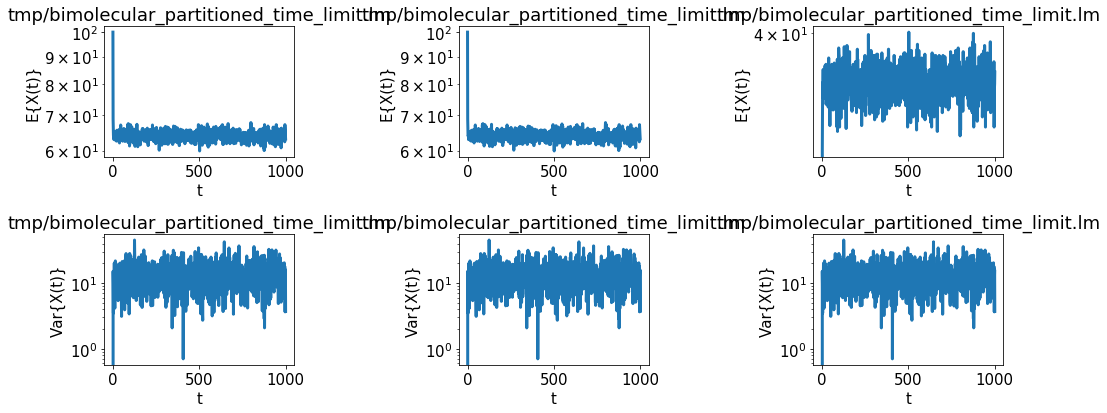

[bimolecular_partitioned_time_limit:1]                       : passed.


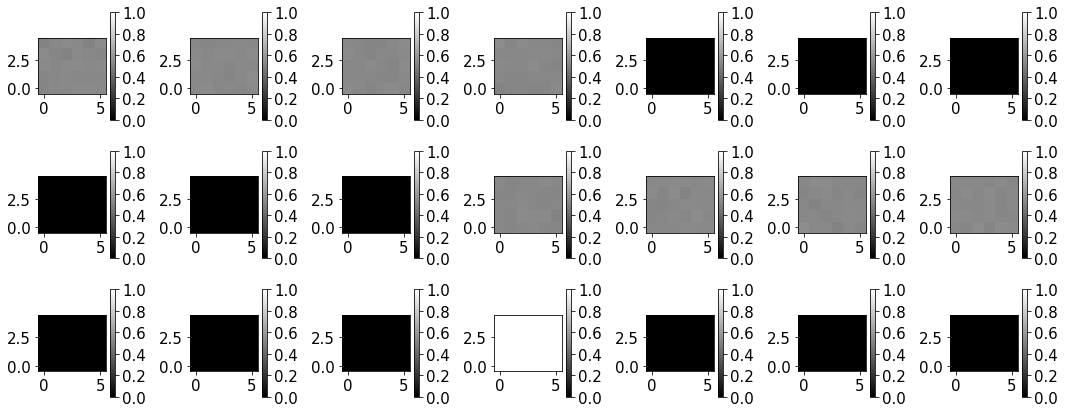

[bimolecular_partitioned_time_limit:2]                       : passed.


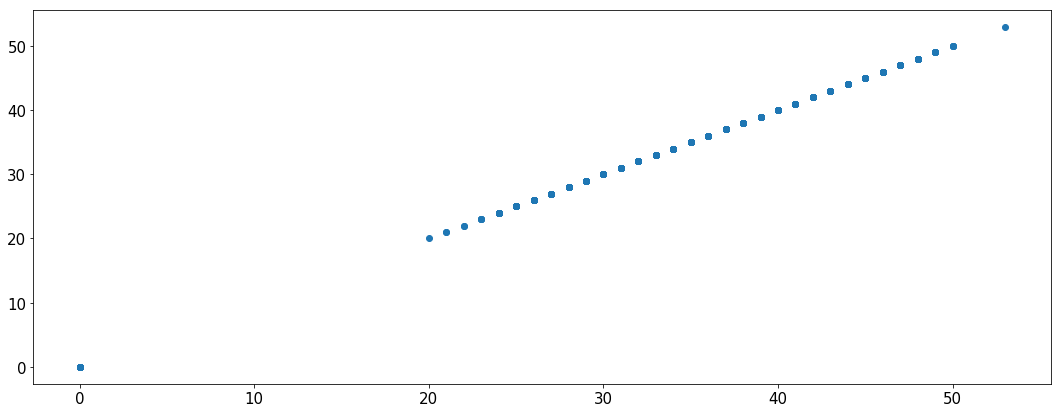

In [17]:
testMethods = {"bimolecular_partitioned_time_limit": [test_bimolecular_time_limit_stats,test_bimolecular_time_limit_density,test_bimolecular_time_limit_compare]}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})
i=1
for testName in testNames:
    for i,testMethod in enumerate(testMethods[testName]):
        try:
            testOutputFilename="tmp/%s.lm"%(testName)
            testMethod(testOutputFilename)
        except Exception as e:
            print "%-60s : FAILED with:"%("["+testName+":"+str(i)+"]"),e
        except:
            print "%-60s : FAILED with: Unknown exception"%("["+testName+":"+str(i)+"]")
        else:
            print "%-60s : passed."%("["+testName+":"+str(i)+"]")
        plt.tight_layout()
        plt.show()
pass

In [18]:
%%bash
rm -rf tmp